#DATA PREPARATION

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('scaled_for_sequences.csv', parse_dates=['Datetime'])

# Features and target
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

X = df[features].values
y = df[target].values

# Train/Val/Test split (70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Reshape for Conv1D & LSTM input: (samples, time_steps=6, features=1)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define input shape
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])


#Hybrid Models

#Sequential CNN -> LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LeakyReLU, Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Input
inp = Input(shape=input_shape)

# CNN Block
x = Conv1D(64, kernel_size=2)(inp)
x = Activation(gelu)(x)
x = Conv1D(128, kernel_size=2)(x)
x = Activation(gelu)(x)
x = Dropout(0.2)(x)

# LSTM Block
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu')(x)

# Dense + LeakyReLU + Output
x = Dense(32)(x)
x = LeakyReLU(alpha=0.01)(x)
out = Dense(1)(x)

# Model
hybrid_model_seq = Model(inputs=inp, outputs=out)
hybrid_model_seq.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])

# Train
history_seq = hybrid_model_seq.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 3503208.5000 - mae: 3503209.2500 - val_loss: 105.3537 - val_mae: 105.8499
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 63.3461 - mae: 63.8443 - val_loss: 115.3393 - val_mae: 115.8383
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 126.4780 - mae: 126.9771 - val_loss: 157.5188 - val_mae: 158.0180
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 146.4081 - mae: 146.9076 - val_loss: 169.2498 - val_mae: 169.7498
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 68.2416 - mae: 68.7401 - val_loss: 223.4394 - val_mae: 223.9386
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 66.8619 - mae: 67.3598 - val_loss: 128.5888 - val_mae: 129.0876
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 80.6247 - mae: 81.1239 - val_loss: 222.3244 - val_mae: 222.8234
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 71.3752 - mae: 71.8729 - val_loss: 194.7958 - val_mae: 195.2952
E


Fold 1
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Fold 1 R²: -0.1111, RMSE: 98.8229, MAE: 68.4884, MAPE: 26.82%

Fold 2
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
Fold 2 R²: -0.0907, RMSE: 88.5101, MAE: 63.2905, MAPE: 21.40%

Fold 3
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Fold 3 R²: -0.0106, RMSE: 88.0092, MAE: 74.1915, MAPE: 22.74%

Fold 4
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
Fold 4 R²: -0.1190, RMSE: 90.9975, MAE: 63.3733, MAPE: 22.81%

Fold 5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Fold 5 R²: -0.1867, RMSE: 91.6266, MAE: 62.0359, MAPE: 22.94%

Final Cross-Validated Metrics:
Mean R²:    -0.1037
Mean RMSE:  91.5932
Mean MAE:   66.2759
Mean MAPE:  23.34%


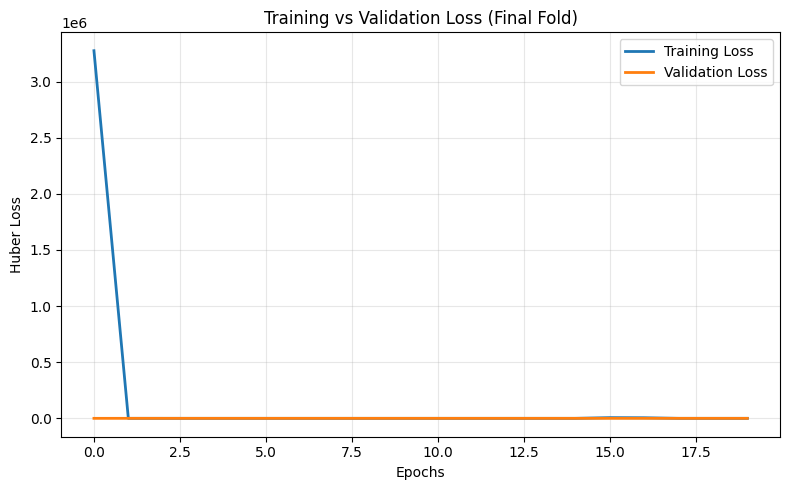

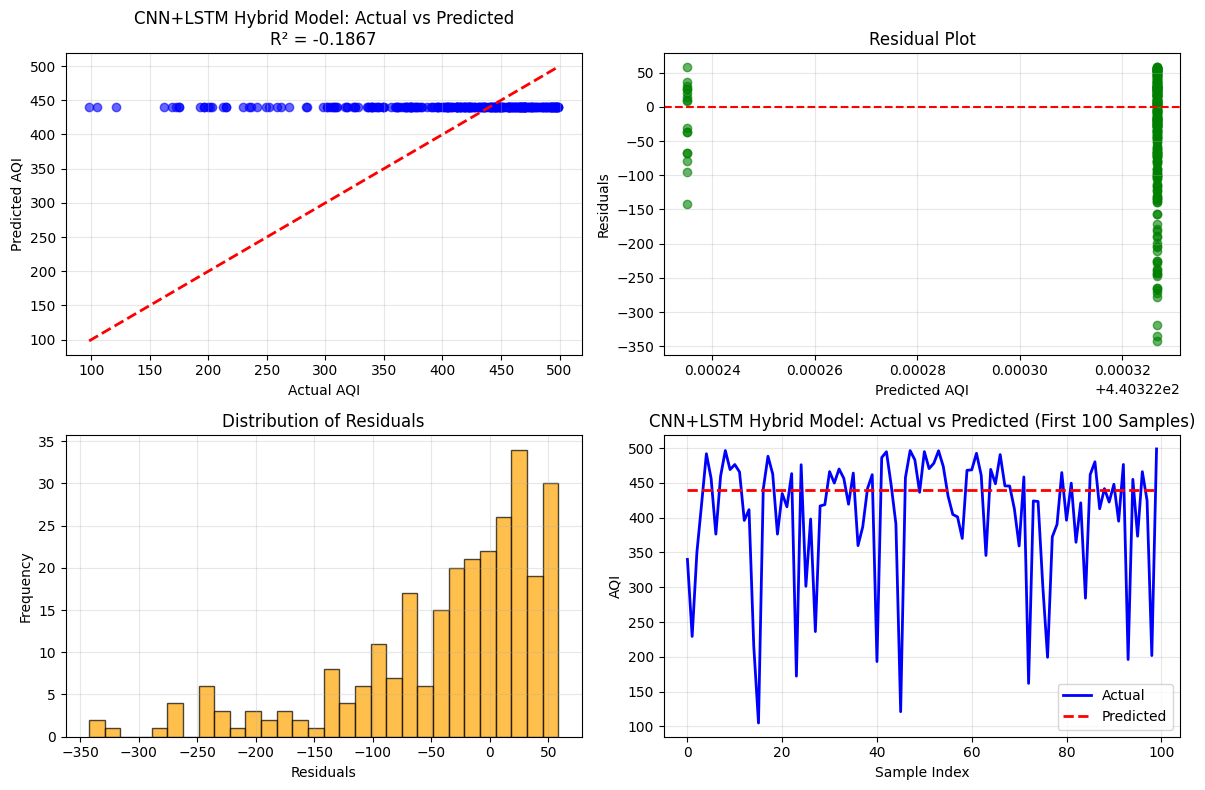

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Your original model definition assumed already loaded:
# hybrid_model_seq = ...

def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

# For plotting
final_y_val, final_preds, final_history = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cnn)):
    print(f"\nFold {fold + 1}")
    X_tr, X_val = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Recreate the model for each fold to reset weights
    model = hybrid_model_seq
    model = tf.keras.models.clone_model(model)
    model.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val_fold),
        epochs=20,
        batch_size=16,
        verbose=0
    )

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val_fold, preds)
    rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    mae = mean_absolute_error(y_val_fold, preds)
    mape = np.mean(np.abs((y_val_fold - preds) / (y_val_fold + 1e-8))) * 100

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    print(f"Fold {fold + 1} R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    if fold == kf.get_n_splits() - 1:
        final_y_val = y_val_fold
        final_preds = preds
        final_history = history

# Cross-Validated Results
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# Final Fold: Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final Fold: Predictions
plot_model_results(final_y_val, final_preds, model_name="CNN+LSTM Hybrid Model")


#Parallel CNN + LSTM

In [ ]:
from tensorflow.keras.layers import Flatten, Concatenate

# Input
inp = Input(shape=input_shape)

# CNN Path
cnn = Conv1D(64, kernel_size=2)(inp)
cnn = Activation(gelu)(cnn)
cnn = Conv1D(128, kernel_size=2)(cnn)
cnn = Activation(gelu)(cnn)
cnn = Flatten()(cnn)

# LSTM Path
lstm = LSTM(128, activation='relu', return_sequences=True)(inp)
lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
lstm = LSTM(128, activation='relu')(lstm)

# Merge CNN and LSTM outputs
merged = Concatenate()([cnn, lstm])

# Dense + LeakyReLU + Output
x = Dense(32)(merged)
x = LeakyReLU(alpha=0.01)(x)
out = Dense(1)(x)

# Model
hybrid_model_parallel = Model(inputs=inp, outputs=out)
hybrid_model_parallel.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])

# Train
history_parallel = hybrid_model_parallel.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 562531.4375 - mae: 562532.0000 - val_loss: 133.1449 - val_mae: 133.6448
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 51.3033 - mae: 51.8012 - val_loss: 62.3924 - val_mae: 62.8910
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 32.4393 - mae: 32.9368 - val_loss: 60.4115 - val_mae: 60.9100
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 36.2053 - mae: 36.7027 - val_loss: 90.2516 - val_mae: 90.7515
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 32.7247 - mae: 33.2220 - val_loss: 102.6150 - val_mae: 103.1142
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 31.8182 - mae: 32.3163 - val_loss: 69.4573 - val_mae: 69.9573
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 23.9677 - mae: 24.4636 - val_loss: 57.1660 - val_mae: 57.6630
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 18.3603 - mae: 18.8551 - val_loss: 30.4239 - val_mae: 30.9228
Epoch 9/20
87/87 ━━━━━━━━━━━━━


Fold 1
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Fold 1 R²: 0.9758, RMSE: 14.5768, MAE: 9.7117, MAPE: 3.47%

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Fold 2 R²: 0.9607, RMSE: 16.8069, MAE: 11.4535, MAPE: 3.51%

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Fold 3 R²: 0.9706, RMSE: 15.0028, MAE: 8.6634, MAPE: 3.16%

Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Fold 4 R²: 0.9266, RMSE: 23.2976, MAE: 20.3410, MAPE: 5.53%

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Fold 5 R²: 0.9305, RMSE: 22.1745, MAE: 17.6141, MAPE: 5.32%

Final Cross-Validated Metrics:
Mean R²:    0.9529
Mean RMSE:  18.3717
Mean MAE:   13.5567
Mean MAPE:  4.20%


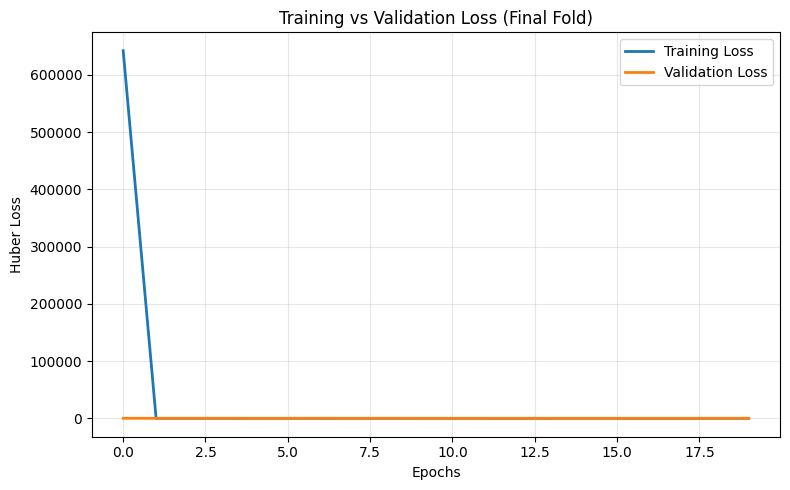

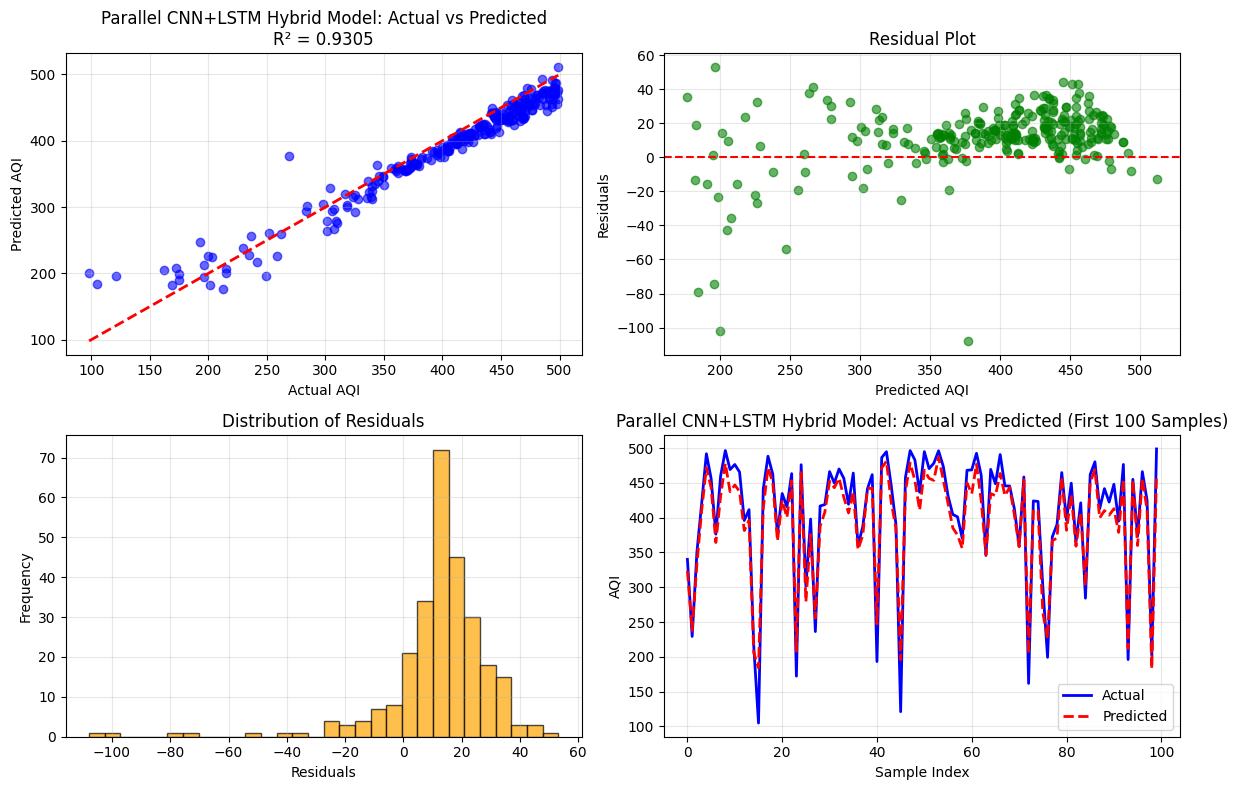

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Plotting function
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Define a function to build the parallel hybrid model (fresh each time)
def create_hybrid_model_parallel(input_shape):
    inp = Input(shape=input_shape)

    # CNN Path
    cnn = Conv1D(64, kernel_size=2)(inp)
    cnn = Activation(gelu)(cnn)
    cnn = Conv1D(128, kernel_size=2)(cnn)
    cnn = Activation(gelu)(cnn)
    cnn = Flatten()(cnn)

    # LSTM Path
    lstm = LSTM(128, activation='relu', return_sequences=True)(inp)
    lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
    lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
    lstm = LSTM(128, activation='relu')(lstm)

    # Merge
    merged = Concatenate()([cnn, lstm])

    # Dense layers
    x = Dense(32)(merged)
    x = LeakyReLU(alpha=0.01)(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])
    return model

# K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

final_y_val, final_preds, final_history = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cnn)):
    print(f"\nFold {fold + 1}")
    X_tr, X_val = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = create_hybrid_model_parallel(input_shape=X_tr.shape[1:])

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val_fold),
        epochs=20,
        batch_size=16,
        verbose=0
    )

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val_fold, preds)
    rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    mae = mean_absolute_error(y_val_fold, preds)
    mape = np.mean(np.abs((y_val_fold - preds) / (y_val_fold + 1e-8))) * 100

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    print(f"Fold {fold + 1} R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    if fold == kf.get_n_splits() - 1:
        final_y_val = y_val_fold
        final_preds = preds
        final_history = history

# Metrics Summary
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# Final Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final Prediction Plot
plot_model_results(final_y_val, final_preds, model_name="Parallel CNN+LSTM Hybrid Model")


#Parallel hybrid ( + attention mechanism )

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Flatten, Dense, LSTM,
    Activation, Concatenate, LeakyReLU,
    Attention, Reshape
)
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Input shape
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])  # (6, 1)
inp = Input(shape=input_shape)

# --- CNN Branch ---
cnn = Conv1D(64, kernel_size=2)(inp)
cnn = Activation(gelu)(cnn)
cnn = Conv1D(128, kernel_size=2)(cnn)
cnn = Activation(gelu)(cnn)
cnn = Flatten()(cnn)

# --- LSTM Branch ---
lstm_out = LSTM(128, activation='relu', return_sequences=True)(inp)
lstm_out = LSTM(128, activation='relu', return_sequences=True)(lstm_out)
lstm_out = LSTM(128, activation='relu', return_sequences=True)(lstm_out)
lstm_out = LSTM(128, activation='relu', return_sequences=True)(lstm_out)

# --- Attention ---
# Attention takes query and value; both are the same here
attention_out = Attention()([lstm_out, lstm_out])  # shape: (batch_size, time_steps, 128)
# Reduce over time steps to a vector (e.g., by flattening or averaging)
attention_out = Flatten()(attention_out)

# --- Merge CNN and Attention output ---
merged = Concatenate()([cnn, attention_out])

# --- Dense + LeakyReLU + Output ---
x = Dense(32)(merged)
x = LeakyReLU(alpha=0.01)(x)
out = Dense(1)(x)

# --- Compile Model ---
hybrid_attention_model = Model(inputs=inp, outputs=out)
hybrid_attention_model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=Huber(),
    metrics=['mae']
)

# --- Train Model ---
history_attention = hybrid_attention_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 6291780.5000 - mae: 6291782.0000 - val_loss: 104.1212 - val_mae: 104.6206
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 48.7773 - mae: 49.2744 - val_loss: 88.8430 - val_mae: 89.3426
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 26.1432 - mae: 26.6390 - val_loss: 54.8749 - val_mae: 55.3737
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 23.7285 - mae: 24.2244 - val_loss: 45.9423 - val_mae: 46.4404
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 24.8126 - mae: 25.3083 - val_loss: 50.6914 - val_mae: 51.1862
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 19.9032 - mae: 20.3989 - val_loss: 35.3784 - val_mae: 35.8776
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 18.9930 - mae: 19.4879 - val_loss: 51.0225 - val_mae: 51.5133
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 14.0849 - mae: 14.5763 - val_loss: 57.0486 - val_mae: 57.5486
Epoch 9/20
87/87 ━━━━━━━━━━━━━


Fold 1
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
Fold 1 R²: 0.9624, RMSE: 18.1872, MAE: 10.7982, MAPE: 4.55%

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Fold 2 R²: 0.9278, RMSE: 22.7660, MAE: 18.9060, MAPE: 5.10%

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Fold 3 R²: 0.9590, RMSE: 17.7287, MAE: 11.9848, MAPE: 3.96%

Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Fold 4 R²: 0.8381, RMSE: 34.6081, MAE: 32.0163, MAPE: 8.82%

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
Fold 5 R²: 0.9095, RMSE: 25.3081, MAE: 21.5371, MAPE: 6.20%

Final Cross-Validated Metrics:
Mean R²:    0.9194
Mean RMSE:  23.7196
Mean MAE:   19.0485
Mean MAPE:  5.72%


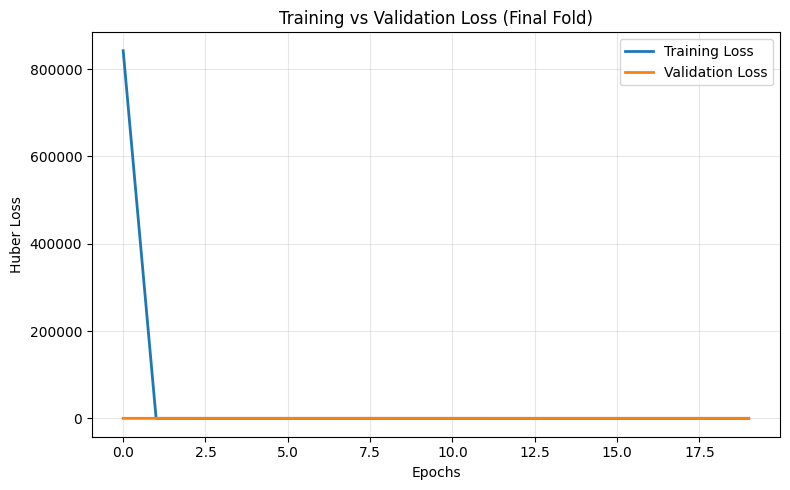

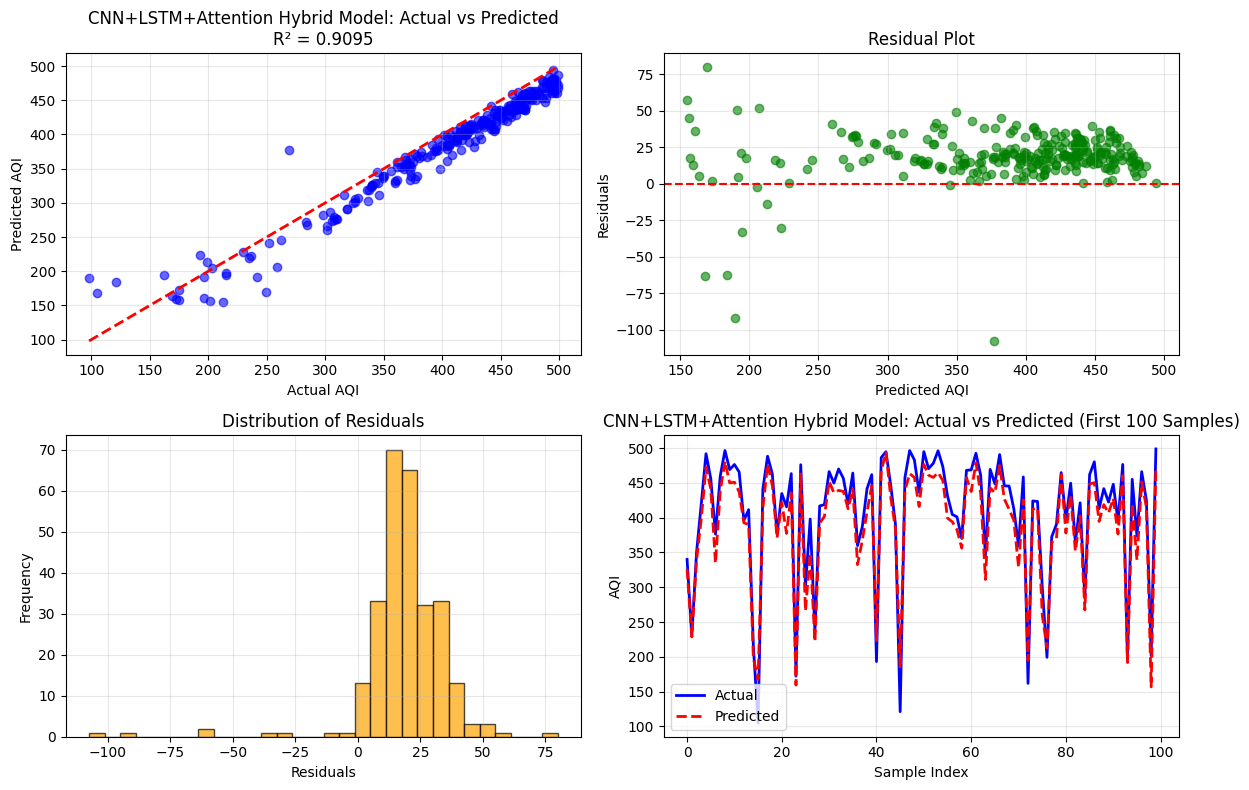

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Flatten, Dense, LSTM,
    Activation, Concatenate, LeakyReLU,
    Attention
)
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# --- Plot Function ---
def plot_model_results(y_test, predictions, model_name="Model"):
    residuals = y_test - predictions
    n_samples = min(100, len(y_test))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'{model_name}: Actual vs Predicted\nR² = {r2_score(y_test, predictions):.4f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    indices = range(n_samples)
    plt.plot(indices, y_test[:n_samples], 'b-', label='Actual', linewidth=2)
    plt.plot(indices, predictions[:n_samples], 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.title(f'{model_name}: Actual vs Predicted (First 100 Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Model Constructor Function ---
def create_hybrid_attention_model(input_shape):
    inp = Input(shape=input_shape)

    # CNN Branch
    cnn = Conv1D(64, kernel_size=2)(inp)
    cnn = Activation(gelu)(cnn)
    cnn = Conv1D(128, kernel_size=2)(cnn)
    cnn = Activation(gelu)(cnn)
    cnn = Flatten()(cnn)

    # LSTM Branch
    lstm_out = LSTM(128, activation='relu', return_sequences=True)(inp)
    lstm_out = LSTM(128, activation='relu', return_sequences=True)(lstm_out)
    lstm_out = LSTM(128, activation='relu', return_sequences=True)(lstm_out)
    lstm_out = LSTM(128, activation='relu', return_sequences=True)(lstm_out)

    # Attention
    attention_out = Attention()([lstm_out, lstm_out])
    attention_out = Flatten()(attention_out)

    # Merge
    merged = Concatenate()([cnn, attention_out])

    # Dense + Output
    x = Dense(32)(merged)
    x = LeakyReLU(alpha=0.01)(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])
    return model

# --- K-Fold CV ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores, cv_rmse_scores, cv_mae_scores, cv_mape_scores = [], [], [], []

final_y_val, final_preds, final_history = None, None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cnn)):
    print(f"\nFold {fold + 1}")
    X_tr, X_val = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = create_hybrid_attention_model(input_shape=X_tr.shape[1:])

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val_fold),
        epochs=20,
        batch_size=16,
        verbose=0
    )

    preds = model.predict(X_val).flatten()

    r2 = r2_score(y_val_fold, preds)
    rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    mae = mean_absolute_error(y_val_fold, preds)
    mape = np.mean(np.abs((y_val_fold - preds) / (y_val_fold + 1e-8))) * 100

    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    cv_mae_scores.append(mae)
    cv_mape_scores.append(mape)

    print(f"Fold {fold + 1} R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    if fold == kf.get_n_splits() - 1:
        final_y_val = y_val_fold
        final_preds = preds
        final_history = history

# --- Metrics Summary ---
print("\nFinal Cross-Validated Metrics:")
print("=" * 40)
print(f"Mean R²:    {np.mean(cv_r2_scores):.4f}")
print(f"Mean RMSE:  {np.mean(cv_rmse_scores):.4f}")
print(f"Mean MAE:   {np.mean(cv_mae_scores):.4f}")
print(f"Mean MAPE:  {np.mean(cv_mape_scores):.2f}%")
print("=" * 40)

# --- Final Fold: Loss Curve ---
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss (Final Fold)')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Final Fold: Prediction Plot ---
plot_model_results(final_y_val, final_preds, model_name="CNN+LSTM+Attention Hybrid Model")


**performs better**
- overall improvement from CNN but less than LSTM

#TRY 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LeakyReLU, Activation, concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Load your CSV (replace with your path)
df = pd.read_csv('scaled_for_sequences.csv')  # Ensure this is scaled already

# Assuming 'AQI' column exists
aqi = df['AQI'].values

# Create sequences of 14 days to predict next-day AQI
timesteps = 14
X, y = [], []
for i in range(len(aqi) - timesteps):
    X.append(aqi[i:i+timesteps])
    y.append(aqi[i+timesteps])

X = np.array(X)
y = np.array(y)

# Reshape: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print("✅ Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


✅ Shapes:
Train: (1369, 14, 1) (1369,)
Val:   (391, 14, 1) (391,)
Test:  (197, 14, 1) (197,)


In [ ]:
input_seq = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (14, 1)

# CNN branch
x_cnn = Conv1D(64, kernel_size=2, activation=gelu)(input_seq)
x_cnn = Conv1D(128, kernel_size=2, activation=gelu)(x_cnn)
x_cnn = Dropout(0.2)(x_cnn)
x_cnn = GlobalAveragePooling1D()(x_cnn)

# LSTM branch
x_lstm = LSTM(128, return_sequences=True)(input_seq)
x_lstm = Dropout(0.2)(x_lstm)
x_lstm = LSTM(128, return_sequences=True)(x_lstm)
x_lstm = Dropout(0.2)(x_lstm)
x_lstm = LSTM(128, return_sequences=True)(x_lstm)
x_lstm = Dropout(0.2)(x_lstm)
x_lstm = LSTM(128)(x_lstm)
x_lstm = Dropout(0.2)(x_lstm)

# Merge
x = concatenate([x_cnn, x_lstm])
x = Dense(32)(x)
x = LeakyReLU(negative_slope=0.01)(x)
output = Dense(1)(x)

# Model
model = Model(inputs=input_seq, outputs=output)

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 14, 128)   │     66,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 14, 128)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 14, 128)   │    131,584 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14, 128)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 13, 64)    │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 14, 128)   │    131,584 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 128)   │     16,512 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 14, 128)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 128)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    131,584 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ leaky_re_lu[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 486,273 (1.85 MB)

 Trainable params: 486,273 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 63.8538 - mae: 64.3529 - val_loss: 55.5805 - val_mae: 56.0787
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 67.8801 - mae: 68.3774 - val_loss: 55.9649 - val_mae: 56.4646
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 65.7949 - mae: 66.2932 - val_loss: 55.2319 - val_mae: 55.7300
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 66.3396 - mae: 66.8378 - val_loss: 55.6349 - val_mae: 56.1334
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 65.8436 - mae: 66.3420 - val_loss: 55.6172 - val_mae: 56.1157
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 68.9800 - mae: 69.4791 - val_loss: 55.7485 - val_mae: 56.2457
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 65.9007 - mae: 66.3992 - val_loss: 55.9594 - val_mae: 56.4593
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 64.1959 - mae: 64.6928 - val_loss: 55.8168 - val_mae: 56.3151
Epoch 9/20
86/86 ━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test).flatten()

# R² Score
r2 = r2_score(y_test, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print all
print("📈 R² Score     :", round(r2, 4))
print("📉 RMSE         :", round(rmse, 4))
print("📊 MAE          :", round(mae, 4))
print("📊 MAPE (%)     :", round(mape, 4))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
📈 R² Score     : 0.4351
📉 RMSE         : 81.0026
📊 MAE          : 63.5926
📊 MAPE (%)     : 37.3308


#try 3

Train: (1369, 14, 1), Val: (392, 14, 1), Test: (196, 14, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 13, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,169 (403.00 KB)

 Trainable params: 103,169 (403.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 399.1642 - mae: 399.6642 - val_loss: 215.3115 - val_mae: 215.8115 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 367.2170 - mae: 367.7170 - val_loss: 180.2715 - val_mae: 180.7709 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 331.5328 - mae: 332.0328 - val_loss: 142.6050 - val_mae: 143.1039 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 277.1095 - mae: 277.6094 - val_loss: 114.0405 - val_mae: 114.5384 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 208.9878 - mae: 209.4877 - val_loss: 116.1874 - val_mae: 116.6873 - learning_rate: 0.0010
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 144.3954 - mae: 144.8954 - val_loss: 137.2397 - val_mae: 137.7362 - learning_rate: 0.0010
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 90.4520 - mae: 90.9510 - val_loss: 176.6352 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

Test Metrics:
  R²   : -0.2444
  RMSE : 119.0042
  MAE  : 90.7400
  MAPE : 38.22%


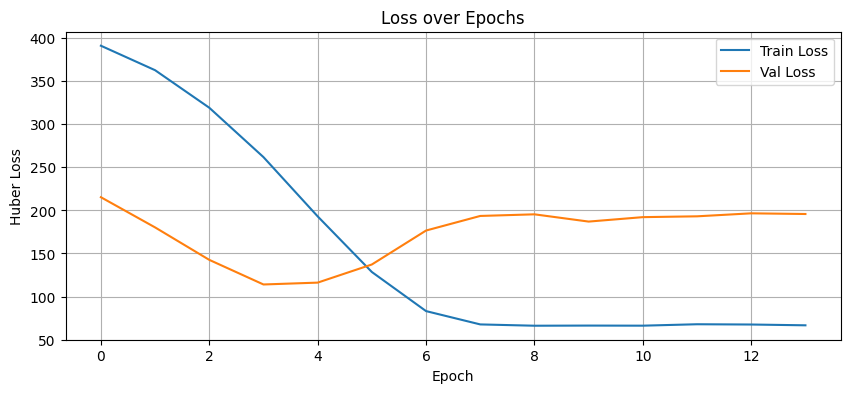

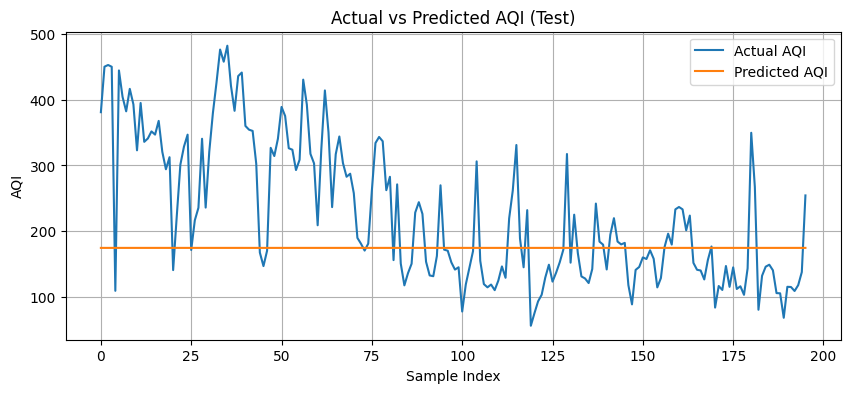

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ─── 1. Load & Preprocess ─────────────────────────────────────
df = pd.read_csv('scaled_for_sequences.csv')  # your pre‑scaled AQI CSV
aqi = df['AQI'].values

timesteps = 14
X, y = [], []
for i in range(len(aqi) - timesteps):
    X.append(aqi[i : i + timesteps])
    y.append(aqi[i + timesteps])
X = np.array(X).reshape(-1, timesteps, 1)
y = np.array(y)

# ─── 2. Time‑Aware Split (70/20/10) ────────────────────────────
n = len(X)
train_end = int(0.7 * n)
val_end   = int(0.9 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ─── 3. Build Stacked CNN → LSTM Hybrid ────────────────────────
model = Sequential([
    # CNN block
    Conv1D(64, kernel_size=2, activation=gelu, input_shape=(timesteps, 1)),
    Dropout(0.2),

    # LSTM block
    LSTM(128),
    Dropout(0.2),

    # Dense
    Dense(32),
    LeakyReLU(negative_slope=0.01),

    # Output
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])
model.summary()

# ─── 4. Train ───────────────────────────────────────────────────
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ─── 5. Evaluate on Test ────────────────────────────────────────
y_pred = model.predict(X_test).flatten()

r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nTest Metrics:")
print(f"  R²   : {r2:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  MAE  : {mae:.4f}")
print(f"  MAPE : {mape:.2f}%")

# ─── 6. Plot Training Curves ────────────────────────────────────
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True)
plt.show()

# ─── 7. Plot Actual vs Predicted ───────────────────────────────
plt.figure(figsize=(10,4))
plt.plot(y_test,  label='Actual AQI')
plt.plot(y_pred,  label='Predicted AQI')
plt.title('Actual vs Predicted AQI (Test)')
plt.xlabel('Sample Index')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# ─── 8. (Optional) Save Model ──────────────────────────────────
# model.save('cnn_lstm_aqi_model.h5')


✅ Train: (1371, 12, 6), Val: (391, 12, 6), Test: (197, 12, 6)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 11, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 11, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,393 (919.50 KB)

 Trainable params: 235,393 (919.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 374.9046 - mae: 375.4046 - val_loss: 149.5862 - val_mae: 150.0846
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 270.1084 - mae: 270.6084 - val_loss: 115.5765 - val_mae: 116.0765
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 129.6013 - mae: 130.1009 - val_loss: 182.1243 - val_mae: 182.6243
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 68.1438 - mae: 68.6436 - val_loss: 194.5982 - val_mae: 195.0982
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 67.0112 - mae: 67.5100 - val_loss: 192.6950 - val_mae: 193.1946
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 63.9617 - mae: 64.4595 - val_loss: 197.4333 - val_mae: 197.9325
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 64.9598 - mae: 65.4586 - val_loss: 194.5699 - val_mae: 195.0699
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 66.5417 - mae: 67.0408 - val_loss: 190.7345 - val_mae: 191.2342
Epoch 9/50

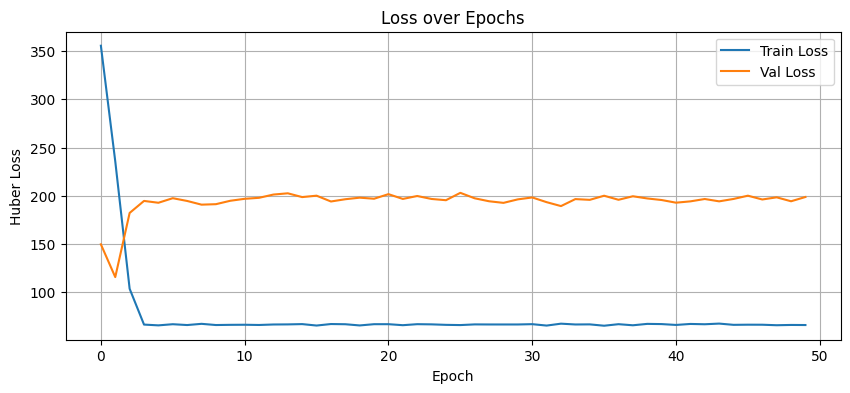

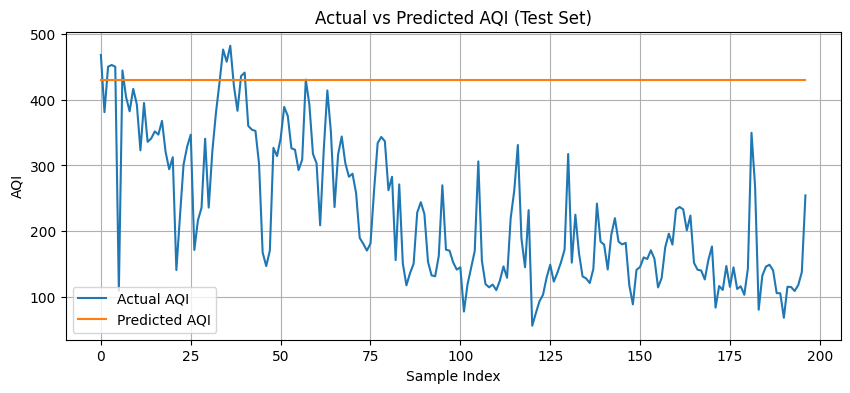

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import Huber

# ─── 1. Load Data ──────────────────────────────────────────────
df = pd.read_csv('scaled_for_sequences.csv')  # Your file

features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

# ─── 2. Feature Scaling ────────────────────────────────────────
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
aqi_values = df[target].values  # Not scaling target

# ─── 3. Create Sequences (length = 12) ─────────────────────────
sequence_length = 12
X, y = [], []

for i in range(len(scaled_features) - sequence_length):
    X.append(scaled_features[i:i+sequence_length])
    y.append(aqi_values[i+sequence_length])

X = np.array(X)  # (samples, 12, 6)
y = np.array(y)

# ─── 4. Train/Val/Test Split (70/20/10) ────────────────────────
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

print(f"✅ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ─── 5. Stacked CNN → LSTM Model ───────────────────────────────
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation=gelu, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),

    LSTM(128, return_sequences=True),
    Dropout(0.2),

    LSTM(128),
    Dropout(0.2),

    Dense(32),
    LeakyReLU(negative_slope=0.01),

    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(),
    metrics=['mae']
)

model.summary()

# ─── 6. Train (No Callbacks) ───────────────────────────────────
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

# ─── 7. Evaluate ───────────────────────────────────────────────
y_pred = model.predict(X_test).flatten()

r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n📊 Test Evaluation Metrics:")
print(f"📈 R² Score     : {r2:.4f}")
print(f"📉 RMSE         : {rmse:.4f}")
print(f"📊 MAE          : {mae:.4f}")
print(f"📊 MAPE (%)     : {mape:.2f}")

# ─── 8. Plot Loss Curve ────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True)
plt.show()

# ─── 9. Plot Actual vs Predicted ───────────────────────────────
plt.figure(figsize=(10,4))
plt.plot(y_test, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs Predicted AQI (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 78465.9453 - val_loss: 7652.6865
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 9998.5625 - val_loss: 7879.5850
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 9033.1953 - val_loss: 9742.7490
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 9373.4365 - val_loss: 9275.1650
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 8567.7920 - val_loss: 11591.7773
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 9699.8818 - val_loss: 10460.0176
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 9533.2510 - val_loss: 10878.2471
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 8931.2500 - val_loss: 11406.3438
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 9381.0820 - val_loss: 12730.8555
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 8722.0117 - val_loss: 12377.9248
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 9132.1963 - val_l

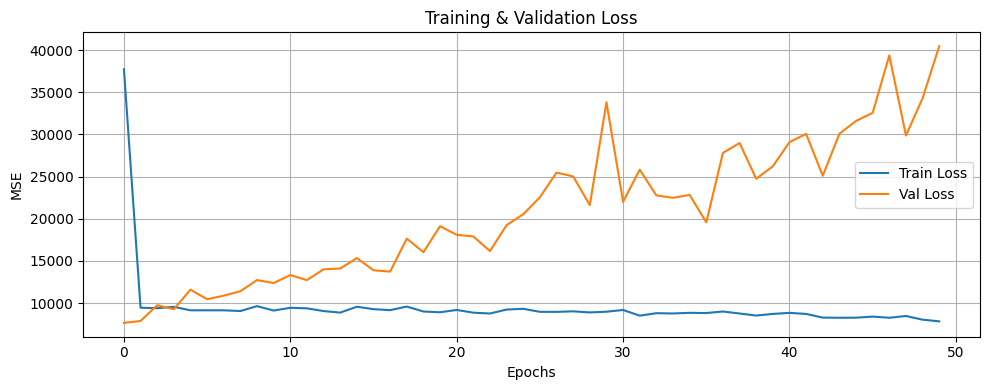

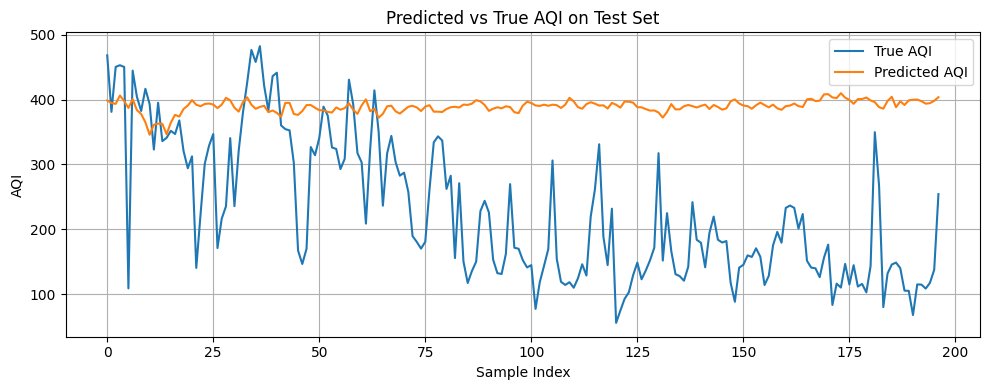

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, LSTM, Dense, Dropout, LeakyReLU, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
import tensorflow as tf

# Load dataset
df = pd.read_csv("scaled_for_sequences.csv")

# Define features and target
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

# Create sequences of length 12
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

data = df[features + [target]].values
X, y = create_sequences(data, seq_length=12)

# Custom Train/Val/Test split (70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Build hybrid CNN-LSTM model
input_layer = Input(shape=(12, 6))

# CNN Branch
cnn = Conv1D(filters=64, kernel_size=3)(input_layer)
cnn = tf.keras.layers.Activation(gelu)(cnn)
cnn = Conv1D(filters=128, kernel_size=3)(cnn)
cnn = tf.keras.layers.Activation(gelu)(cnn)
cnn = Flatten()(cnn)

# LSTM Branch
lstm = LSTM(128, return_sequences=True)(input_layer)
lstm = LSTM(128, return_sequences=True)(lstm)
lstm = LSTM(128, return_sequences=True)(lstm)
lstm = LSTM(128)(lstm)
lstm = LeakyReLU()(lstm)

# Merge branches
merged = Concatenate()([cnn, lstm])
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.3)(merged)
output = Dense(1)(merged)

# Compile model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot predictions vs actual AQI
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='True AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title("Predicted vs True AQI on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.3 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, LSTM, Dense, Dropout, LeakyReLU, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu, relu, selu
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Load data
df = pd.read_csv("scaled_for_sequences.csv")
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

data = df[features + [target]].values
X, y = create_sequences(data, seq_length=12)

# Custom split: 70/20/10
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Activation function map
activation_map = {
    'relu': tf.keras.activations.relu,
    'gelu': tf.keras.activations.gelu,
    'selu': tf.keras.activations.selu
}

# Optuna objective function
def objective(trial):
    # Hyperparameters to tune
    filters1 = trial.suggest_categorical('filters1', [32, 64, 128])
    filters2 = trial.suggest_categorical('filters2', [64, 128, 256])
    lstm_units = trial.suggest_categorical('lstm_units', [64, 128, 256])
    dense_units = trial.suggest_categorical('dense_units', [64, 128, 256])
    dropout_rate = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    act = trial.suggest_categorical('activation', ['relu', 'gelu', 'selu'])

    # Model
    input_layer = Input(shape=(12, 6))

    # CNN Branch
    cnn = Conv1D(filters=filters1, kernel_size=3)(input_layer)
    cnn = tf.keras.layers.Activation(activation_map[act])(cnn)
    cnn = Conv1D(filters=filters2, kernel_size=3)(cnn)
    cnn = tf.keras.layers.Activation(activation_map[act])(cnn)
    cnn = Flatten()(cnn)

    # LSTM Branch
    lstm = LSTM(lstm_units, return_sequences=True)(input_layer)
    lstm = LSTM(lstm_units, return_sequences=True)(lstm)
    lstm = LSTM(lstm_units, return_sequences=True)(lstm)
    lstm = LSTM(lstm_units)(lstm)
    lstm = LeakyReLU()(lstm)

    # Merge
    merged = Concatenate()([cnn, lstm])
    merged = Dense(dense_units, activation=activation_map[act])(merged)
    merged = Dropout(dropout_rate)(merged)
    output = Dense(1)(merged)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Train
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=20,  # shorter for tuning
                        batch_size=batch_size,
                        verbose=0)

    # Predict and evaluate on validation
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

# Run study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Show best trial
print("\nBest Hyperparameters:")
for key, val in study.best_trial.params.items():
    print(f"{key}: {val}")
print(f"Validation MSE: {study.best_value:.4f}")



[I 2025-07-15 17:17:05,196] A new study created in memory with name: no-name-f4adc125-a579-49ab-a9d8-71e9e187ca58


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


[I 2025-07-15 17:19:03,612] Trial 0 finished with value: 7346.552377416559 and parameters: {'filters1': 64, 'filters2': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout': 0.3603442775760309, 'lr': 0.001045362061382296, 'batch_size': 32, 'activation': 'relu'}. Best is trial 0 with value: 7346.552377416559.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


[I 2025-07-15 17:20:53,963] Trial 1 finished with value: 29899.54581756837 and parameters: {'filters1': 64, 'filters2': 128, 'lstm_units': 128, 'dense_units': 128, 'dropout': 0.22332350273475685, 'lr': 0.0051393313267239496, 'batch_size': 32, 'activation': 'relu'}. Best is trial 0 with value: 7346.552377416559.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-07-15 17:21:45,294] Trial 2 finished with value: 7215.924694894536 and parameters: {'filters1': 32, 'filters2': 128, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.24007324040644096, 'lr': 0.0007711600486369246, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


[I 2025-07-15 17:23:37,763] Trial 3 finished with value: 7929.948331156258 and parameters: {'filters1': 64, 'filters2': 256, 'lstm_units': 128, 'dense_units': 256, 'dropout': 0.4685248941226218, 'lr': 0.00021784161085516848, 'batch_size': 16, 'activation': 'selu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


[I 2025-07-15 17:24:51,970] Trial 4 finished with value: 17010.975559520328 and parameters: {'filters1': 64, 'filters2': 128, 'lstm_units': 128, 'dense_units': 256, 'dropout': 0.3783960160342775, 'lr': 0.0054488890872283705, 'batch_size': 64, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


[I 2025-07-15 17:28:26,772] Trial 5 finished with value: 13555.917174436745 and parameters: {'filters1': 64, 'filters2': 64, 'lstm_units': 256, 'dense_units': 64, 'dropout': 0.30547863693426114, 'lr': 0.007783546367904766, 'batch_size': 64, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


[I 2025-07-15 17:31:43,776] Trial 6 finished with value: 8248.905326150794 and parameters: {'filters1': 128, 'filters2': 128, 'lstm_units': 256, 'dense_units': 256, 'dropout': 0.40188547151462173, 'lr': 0.0002681900907299879, 'batch_size': 64, 'activation': 'selu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


[I 2025-07-15 17:33:30,849] Trial 7 finished with value: 9404.936306455345 and parameters: {'filters1': 64, 'filters2': 128, 'lstm_units': 128, 'dense_units': 128, 'dropout': 0.33377538201172086, 'lr': 0.0004398566537734417, 'batch_size': 16, 'activation': 'gelu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-07-15 17:34:15,710] Trial 8 finished with value: 7454.759889352264 and parameters: {'filters1': 32, 'filters2': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.30715991965547296, 'lr': 0.000301358569662468, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


[I 2025-07-15 17:35:11,444] Trial 9 finished with value: 7852.425520753352 and parameters: {'filters1': 64, 'filters2': 128, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.4758475434048778, 'lr': 0.00017384020286218972, 'batch_size': 32, 'activation': 'gelu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-07-15 17:36:05,854] Trial 10 finished with value: 12602.318734712106 and parameters: {'filters1': 32, 'filters2': 256, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.20037443897658017, 'lr': 0.0014833716821796117, 'batch_size': 32, 'activation': 'gelu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-07-15 17:36:47,306] Trial 11 finished with value: 7276.436413614099 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2626247508792933, 'lr': 0.0011014161080698847, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


[I 2025-07-15 17:37:28,407] Trial 12 finished with value: 7237.790947528428 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.26169140837472094, 'lr': 0.0018361944007461051, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-07-15 17:38:20,922] Trial 13 finished with value: 12806.404478160233 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.2541622359296106, 'lr': 0.00229997032102332, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-07-15 17:39:00,701] Trial 14 finished with value: 10007.844690851369 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.26303091074528934, 'lr': 0.0026458337131018174, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-07-15 17:40:34,654] Trial 15 finished with value: 19091.519741784246 and parameters: {'filters1': 128, 'filters2': 256, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.29383328293170957, 'lr': 0.0004918328260512916, 'batch_size': 16, 'activation': 'selu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step


[I 2025-07-15 17:44:02,958] Trial 16 finished with value: 7625.691304122131 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 256, 'dense_units': 64, 'dropout': 0.22776476630713857, 'lr': 0.0006926256121874712, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step


[I 2025-07-15 17:45:00,005] Trial 17 finished with value: 7714.630027340725 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.42776334898890267, 'lr': 0.00011736976693903597, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-07-15 17:46:10,287] Trial 18 finished with value: 13506.655430638815 and parameters: {'filters1': 32, 'filters2': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.27958684183774235, 'lr': 0.0030337574289374873, 'batch_size': 16, 'activation': 'selu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-07-15 17:46:47,408] Trial 19 finished with value: 7581.986113114692 and parameters: {'filters1': 128, 'filters2': 256, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.32876272466438033, 'lr': 0.0015514965459906618, 'batch_size': 64, 'activation': 'gelu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


[I 2025-07-15 17:50:17,624] Trial 20 finished with value: 10638.992305585227 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 256, 'dense_units': 256, 'dropout': 0.2232459531876427, 'lr': 0.0007905397733794972, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step


[I 2025-07-15 17:51:00,033] Trial 21 finished with value: 7553.934945891973 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2587068837696269, 'lr': 0.0013478621128793064, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 7215.924694894536.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


[I 2025-07-15 17:51:52,471] Trial 22 finished with value: 6686.075852885833 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2015859932288374, 'lr': 0.0006382236068652644, 'batch_size': 32, 'activation': 'relu'}. Best is trial 22 with value: 6686.075852885833.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-07-15 17:52:33,943] Trial 23 finished with value: 6758.0561115739065 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.20499225875418003, 'lr': 0.00046144311538255433, 'batch_size': 32, 'activation': 'relu'}. Best is trial 22 with value: 6686.075852885833.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-07-15 17:53:14,525] Trial 24 finished with value: 7639.35149042569 and parameters: {'filters1': 32, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.203276242913285, 'lr': 0.0005156261631979966, 'batch_size': 32, 'activation': 'relu'}. Best is trial 22 with value: 6686.075852885833.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-07-15 17:54:03,175] Trial 25 finished with value: 7187.931930420883 and parameters: {'filters1': 32, 'filters2': 128, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.23067922028768414, 'lr': 0.0006844501443097264, 'batch_size': 32, 'activation': 'relu'}. Best is trial 22 with value: 6686.075852885833.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-07-15 17:54:44,925] Trial 26 finished with value: 6900.238443446861 and parameters: {'filters1': 128, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.20530144375456658, 'lr': 0.0003620284916202934, 'batch_size': 32, 'activation': 'relu'}. Best is trial 22 with value: 6686.075852885833.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


[I 2025-07-15 17:55:37,977] Trial 27 finished with value: 7124.787792385358 and parameters: {'filters1': 128, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.20412390619645182, 'lr': 0.00032795448877281604, 'batch_size': 32, 'activation': 'relu'}. Best is trial 22 with value: 6686.075852885833.


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


[I 2025-07-15 18:02:12,473] Trial 28 finished with value: 7753.944113147542 and parameters: {'filters1': 128, 'filters2': 64, 'lstm_units': 256, 'dense_units': 64, 'dropout': 0.2797487102906153, 'lr': 0.0001444124561857763, 'batch_size': 16, 'activation': 'selu'}. Best is trial 22 with value: 6686.075852885833.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-07-15 18:02:51,109] Trial 29 finished with value: 7223.755307380565 and parameters: {'filters1': 128, 'filters2': 64, 'lstm_units': 64, 'dense_units': 64, 'dropout': 0.358935187937235, 'lr': 0.00038744390697793217, 'batch_size': 64, 'activation': 'gelu'}. Best is trial 22 with value: 6686.075852885833.



Best Hyperparameters:
filters1: 32
filters2: 64
lstm_units: 64
dense_units: 64
dropout: 0.2015859932288374
lr: 0.0006382236068652644
batch_size: 32
activation: relu
Validation MSE: 6686.0759


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 163975.8438 - val_loss: 55141.4219
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 77552.6250 - val_loss: 8223.7471
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 10529.5449 - val_loss: 8542.5635
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 10222.7588 - val_loss: 8798.1172
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9668.8174 - val_loss: 9036.5986
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 10361.1299 - val_loss: 8399.3750
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 10271.7119 - val_loss: 8084.0347
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 10379.5029 - val_loss: 8349.3359
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9881.2969 - val_loss: 8432.5283
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 10589.2275 - val_loss: 8065.3633
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 10689.2930 - val_l

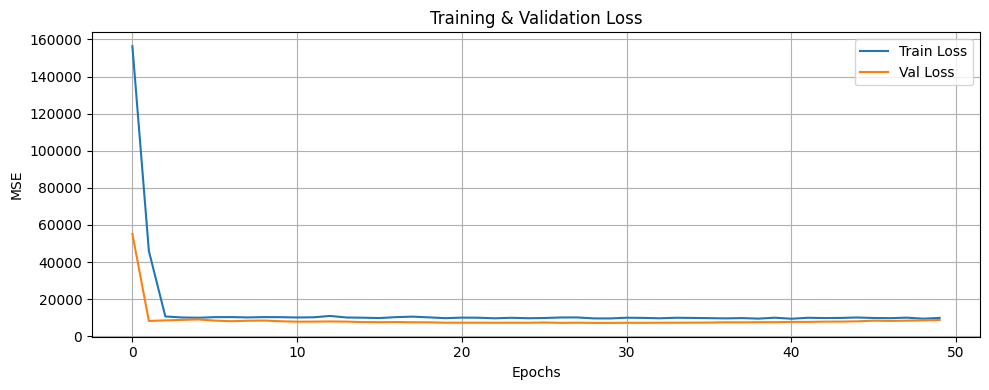

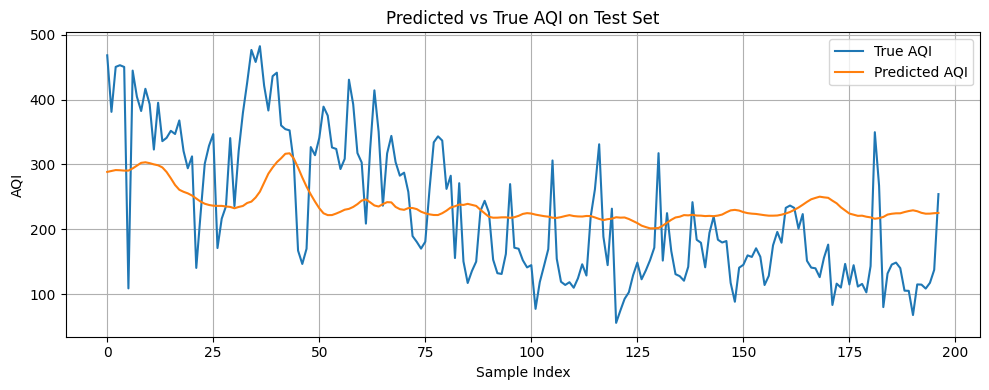

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, LSTM, Dense, Dropout, LeakyReLU, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
import tensorflow as tf

# Load and prepare the data
df = pd.read_csv("scaled_for_sequences.csv")
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

data = df[features + [target]].values
X, y = create_sequences(data, seq_length=12)

# Custom Train/Val/Test split (70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# === Build Hybrid Model using Best Hyperparameters ===
input_layer = Input(shape=(12, 6))

# CNN Branch
cnn = Conv1D(filters=32, kernel_size=3)(input_layer)
cnn = tf.keras.layers.Activation(relu)(cnn)
cnn = Conv1D(filters=64, kernel_size=3)(cnn)
cnn = tf.keras.layers.Activation(relu)(cnn)
cnn = Flatten()(cnn)

# LSTM Branch
lstm = LSTM(64, return_sequences=True)(input_layer)
lstm = LSTM(64, return_sequences=True)(lstm)
lstm = LSTM(64, return_sequences=True)(lstm)
lstm = LSTM(64)(lstm)
lstm = LeakyReLU()(lstm)

# Merge branches
merged = Concatenate()([cnn, lstm])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2016)(merged)
output = Dense(1)(merged)

# Compile model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0006382), loss='mse')

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Plot training & validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot predictions vs true AQI
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='True AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title("Predicted vs True AQI on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, LSTM, Dense, Dropout, LeakyReLU, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
import tensorflow as tf

# Input shape: (sequence_length=12, features=6)
input_layer = Input(shape=(12, 6))

# CNN Branch
cnn = Conv1D(filters=32, kernel_size=3)(input_layer)
cnn = tf.keras.layers.Activation(relu)(cnn)
cnn = Dropout(0.25)(cnn)
cnn = Conv1D(filters=64, kernel_size=3)(cnn)
cnn = tf.keras.layers.Activation(relu)(cnn)
cnn = Dropout(0.25)(cnn)
cnn = Flatten()(cnn)

# LSTM Branch (simplified: 2 layers)
lstm = LSTM(64, return_sequences=True)(input_layer)
lstm = Dropout(0.25)(lstm)
lstm = LSTM(64)(lstm)
lstm = Dropout(0.25)(lstm)
lstm = LeakyReLU()(lstm)

# Merge both branches
merged = Concatenate()([cnn, lstm])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2)(merged)
output = Dense(1)(merged)

# Compile model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0006382), loss='mse')

# model.fit(...)  # Train using your preprocessed data


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 17.6849 - val_loss: 5.9130
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7187 - val_loss: 5.1617
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6576 - val_loss: 4.9751
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.6358 - val_loss: 4.0427
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.5437 - val_loss: 3.1829
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5401 - val_loss: 2.7474
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4529 - val_loss: 2.3385
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4612 - val_loss: 2.0757
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.4241 - val_loss: 1.8209
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4030 - val_loss: 1.5067
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3981 - val_loss: 1.3570
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


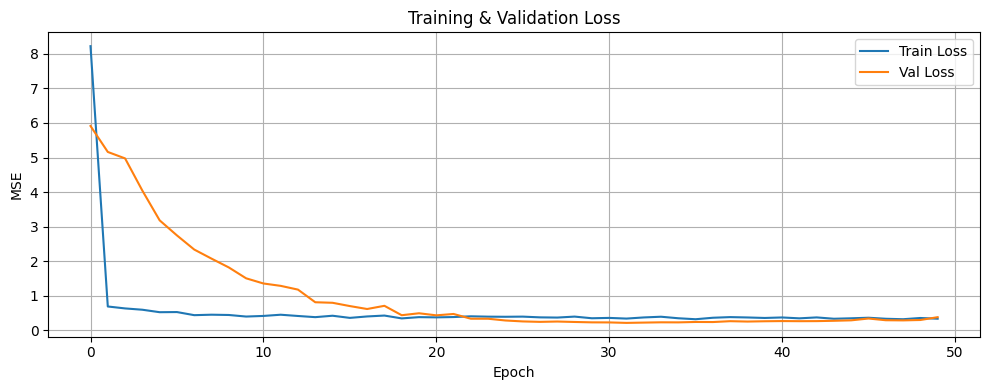

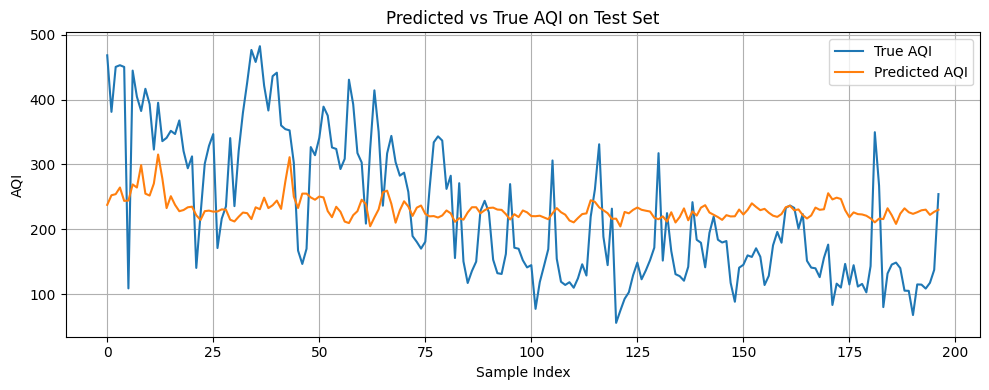

In [ ]:
# Re-import necessary packages after code execution environment reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, LSTM, Dense, Dropout, LeakyReLU, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
import tensorflow as tf

# Load and prepare data
df = pd.read_csv("scaled_for_sequences.csv")
features = ['PM2.5', 'PM10', 'NO', 'NOx', 'CO', 'O3']
target = 'AQI'

# Apply log1p to AQI (label transform)
df[target] = np.log1p(df[target])

# Overlapping sequence generator
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

data = df[features + [target]].values
X, y = create_sequences(data, seq_length=12)

# Custom Train/Val/Test split (70/20/10)
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Build the hybrid CNN-LSTM model (with tuned parameters)
input_layer = Input(shape=(12, 6))

cnn = Conv1D(filters=32, kernel_size=3)(input_layer)
cnn = tf.keras.layers.Activation(relu)(cnn)
cnn = Conv1D(filters=64, kernel_size=3)(cnn)
cnn = tf.keras.layers.Activation(relu)(cnn)
cnn = Flatten()(cnn)

lstm = LSTM(64, return_sequences=True)(input_layer)
lstm = LSTM(64, return_sequences=True)(lstm)
lstm = LSTM(64, return_sequences=True)(lstm)
lstm = LSTM(64)(lstm)
lstm = LeakyReLU()(lstm)

merged = Concatenate()([cnn, lstm])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2016)(merged)
output = Dense(1)(merged)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0006382), loss='mse')

# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

# Predict and inverse log transform
y_pred = model.predict(X_test)
y_pred_inv = np.expm1(y_pred)
y_test_inv = np.expm1(y_test)

# Evaluate
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Plot loss curves
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot predictions vs ground truth
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='True AQI')
plt.plot(y_pred_inv, label='Predicted AQI')
plt.title("Predicted vs True AQI on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Already predicted: y_pred_inv and true: y_test_inv

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print nicely
print(f"📊 Evaluation Metrics:")
print(f"R² Score  : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"MAPE      : {mape * 100:.2f}%")


📊 Evaluation Metrics:
R² Score  : 0.0894
RMSE      : 102.8434
MAE       : 89.6056
MAPE      : 49.39%


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LeakyReLU, Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Input
inp = Input(shape=input_shape)

# CNN Block
x = Conv1D(64, kernel_size=2)(inp)
x = Activation(gelu)(x)
x = Conv1D(128, kernel_size=2)(x)
x = Activation(gelu)(x)
x = Dropout(0.2)(x)

# LSTM Block
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu')(x)

# Dense + LeakyReLU + Output
x = Dense(32)(x)
x = LeakyReLU(alpha=0.01)(x)
out = Dense(1)(x)

# Model
hybrid_model_seq = Model(inputs=inp, outputs=out)
hybrid_model_seq.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])

# Train
history_seq = hybrid_model_seq.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 7617235.0000 - mae: 7617235.0000 - val_loss: 228.5924 - val_mae: 229.0924
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 390.1076 - mae: 390.6076 - val_loss: 210.2556 - val_mae: 210.7556
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 365.4059 - mae: 365.9059 - val_loss: 179.4806 - val_mae: 179.9806
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 332.0289 - mae: 332.5289 - val_loss: 147.3675 - val_mae: 147.8675
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 289.9440 - mae: 290.4440 - val_loss: 119.7365 - val_mae: 120.2352
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 204.7079 - mae: 205.2076 - val_loss: 208.4906 - val_mae: 208.9902
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 62.4254 - mae: 62.9235 - val_loss: 179.4325 - val_mae: 179.9319
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 66.1984 - mae: 66.6964 - val_loss: 181.0049 - val_mae: 181.

In [ ]:
from tensorflow.keras.layers import Flatten, Concatenate

# Input
inp = Input(shape=input_shape)

# CNN Path
cnn = Conv1D(64, kernel_size=2)(inp)
cnn = Activation(gelu)(cnn)
cnn = Conv1D(128, kernel_size=2)(cnn)
cnn = Activation(gelu)(cnn)
cnn = Flatten()(cnn)

# LSTM Path
lstm = LSTM(128, activation='relu', return_sequences=True)(inp)
lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
lstm = LSTM(128, activation='relu')(lstm)

# Merge CNN and LSTM outputs
merged = Concatenate()([cnn, lstm])

# Dense + LeakyReLU + Output
x = Dense(32)(merged)
x = LeakyReLU(alpha=0.01)(x)
out = Dense(1)(x)

# Model
hybrid_model_parallel = Model(inputs=inp, outputs=out)
hybrid_model_parallel.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])

# Train
history_parallel = hybrid_model_parallel.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 3286099.7500 - mae: 3286100.5000 - val_loss: 118.7388 - val_mae: 119.2388
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 64.1662 - mae: 64.6658 - val_loss: 58.8899 - val_mae: 59.3899
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 54.7912 - mae: 55.2897 - val_loss: 99.7933 - val_mae: 100.2933
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 55.0242 - mae: 55.5238 - val_loss: 62.5187 - val_mae: 63.0187
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 24.1784 - mae: 24.6734 - val_loss: 48.2309 - val_mae: 48.7291
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 35.1774 - mae: 35.6746 - val_loss: 48.6850 - val_mae: 49.1840
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 24.0343 - mae: 24.5329 - val_loss: 61.6096 - val_mae: 62.1067
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 20.9234 - mae: 21.4180 - val_loss: 42.9592 - val_mae: 43.4530
Epoch 9/50
44/44 ━━━━━━━━━━━━

In [ ]:
def evaluate_model(model, name='Model'):
    y_pred = model.predict(X_test_cnn).flatten()
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"📊 Evaluation Results for {name}")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print("="*40)
    return r2, rmse, mae, mape

# Evaluate both
evaluate_model(hybrid_model_seq, name='Sequential Hybrid')
evaluate_model(hybrid_model_parallel, name='Parallel Hybrid')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📊 Evaluation Results for Sequential Hybrid
R² Score: -3.6533
RMSE: 232.7398
MAE: 208.2899
MAPE: 1.3925
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
📊 Evaluation Results for Parallel Hybrid
R² Score: 0.8420
RMSE: 42.8853
MAE: 23.1249
MAPE: 0.1764


(0.8420064280623832,
 np.float64(42.88528932375127),
 23.124941107239387,
 0.17639776443920335)

In [ ]:
rom tensorflow.keras.layers import Flatten, Concatenate

# Input
inp = Input(shape=input_shape)

# CNN Path
cnn = Conv1D(64, kernel_size=2)(inp)
cnn = Activation(gelu)(cnn)
cnn = Conv1D(128, kernel_size=2)(cnn)
cnn = Activation(gelu)(cnn)
cnn = Flatten()(cnn)

# LSTM Path
lstm = LSTM(128, activation='relu', return_sequences=True)(inp)
lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
lstm = LSTM(128, activation='relu', return_sequences=True)(lstm)
lstm = LSTM(128, activation='relu')(lstm)

# Merge CNN and LSTM outputs
merged = Concatenate()([cnn, lstm])

# Dense + LeakyReLU + Output
x = Dense(32)(merged)
x = LeakyReLU(alpha=0.01)(x)
out = Dense(1)(x)

# Model
hybrid_model_parallel = Model(inputs=inp, outputs=out)
hybrid_model_parallel.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])

# Train
history_parallel = hybrid_model_parallel.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)
